In [16]:
import torch
import matplotlib.pyplot as plt
from pytorch_msssim import SSIM
import numpy as np
import images
import augmentations
import torchvision
import Lossv2
import torch.nn as nn
image = torchvision.io.read_image("../../Data/Kodak/kodim01.png")


def load_ckp(model, optimizer, checkpoint_fpath="./models/rest/77_checkpoint.pt"):
        checkpoint = torch.load(checkpoint_fpath)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        return model, optimizer, checkpoint['epoch'], checkpoint['index'], checkpoint['min_lr'], checkpoint['max_lr'], checkpoint['steps'], checkpoint['step_size'], checkpoint['falling']

class SSIM_Loss(SSIM):
    def forward(self, img1, img2):
        self.data_range=1.0
        return (super(SSIM_Loss, self).forward(img1, img2))
    

model = Lossv2.Loss(seperable=False, slim=True).to("cuda").to(memory_format=torch.channels_last)
optimizer = torch.optim.SGD(model.parameters(), lr=0)
model = load_ckp(model,optimizer,"/work3/s194042/DeepLearningBachelorProject/Code/Image_functions/Loss1_lr_0_004_0_001/Checkpoints/Loss1_lr_0_004_0_001_147_checkpoint.pt")[0]


def loss(x_org, y_org):
    x = torch.clone(x_org)
    y = torch.clone(y_org)
    x *= 255
    y *= 255
    extra = torch.zeros(2, 512, 768, device=torch.device('cuda'),dtype=torch.float32)
    cat = torch.concatenate((torch.divide(torch.subtract(x.squeeze(0), 128), 128), extra), axis=0).unsqueeze(0)
    inp = torch.concatenate((cat, torch.subtract(x, y)), axis=1).to(memory_format=torch.channels_last)
    return model(inp).squeeze(0).squeeze(0)

def imshowpair(img1, img2, size=15):
    img1 *= 255
    img2 *= 255
    im1 = torch.clone(img1.squeeze(0).permute(1,2,0))
    im1 = im1.detach().cpu().numpy()
    im1 = np.rint(im1)
    im1 = im1.astype(np.uint8)

    im2 = torch.clone(img2.squeeze(0).permute(1,2,0))
    im2 = im2.detach().cpu().numpy()
    im2 = np.rint(im2)
    im2 = im2.astype(np.uint8)
    f, ax = plt.subplots(1,2)

    f.set_figheight(size)
    f.set_figwidth(size)
    
    ax[0].imshow(im1)
    ax[1].imshow(im2)

In [17]:
WHITE222 = torch.ones((1,3,512,768), device="cuda") * 222 / 255
WHITE253 = torch.ones((1,3,512,768), device="cuda") * 253 / 255
WHITE255 = torch.ones((1,3,512,768), device="cuda") * 255 / 255
GREY128 = torch.ones((1,3,512,768), device="cuda") * 128 / 255
GREY130 = torch.ones((1,3,512,768), device="cuda") * 130 / 255
BLACK0 = torch.ones((1,3,512,768), device="cuda") * 0 / 255
BLACK2 = torch.ones((1,3,512,768), device="cuda") * 2 / 255
BLACK26 = torch.ones((1,3,512,768), device="cuda") * 26 / 255
test_images1 = [(WHITE253.clone(),WHITE255.clone()),(GREY128.clone(),GREY130.clone()),(BLACK0.clone(),BLACK2.clone()),(WHITE222.clone(),WHITE255.clone()),(BLACK0.clone(),BLACK26.clone())]

In [18]:
[[f(*im) for im in test_images1] for f in [SSIM_Loss().forward,nn.MSELoss(), loss]]

[[tensor(1.0000, device='cuda:0'),
  tensor(1.0000, device='cuda:0'),
  tensor(0.6191, device='cuda:0'),
  tensor(0.9903, device='cuda:0'),
  tensor(0.0095, device='cuda:0')],
 [tensor(6.1514e-05, device='cuda:0'),
  tensor(6.1515e-05, device='cuda:0'),
  tensor(6.1515e-05, device='cuda:0'),
  tensor(0.0167, device='cuda:0'),
  tensor(0.0104, device='cuda:0')],
 [tensor(0.3275, device='cuda:0'),
  tensor(0.0418, device='cuda:0'),
  tensor(0.0170, device='cuda:0'),
  tensor(0.3502, device='cuda:0'),
  tensor(0.3017, device='cuda:0')]]

[None, None, None, None, None]

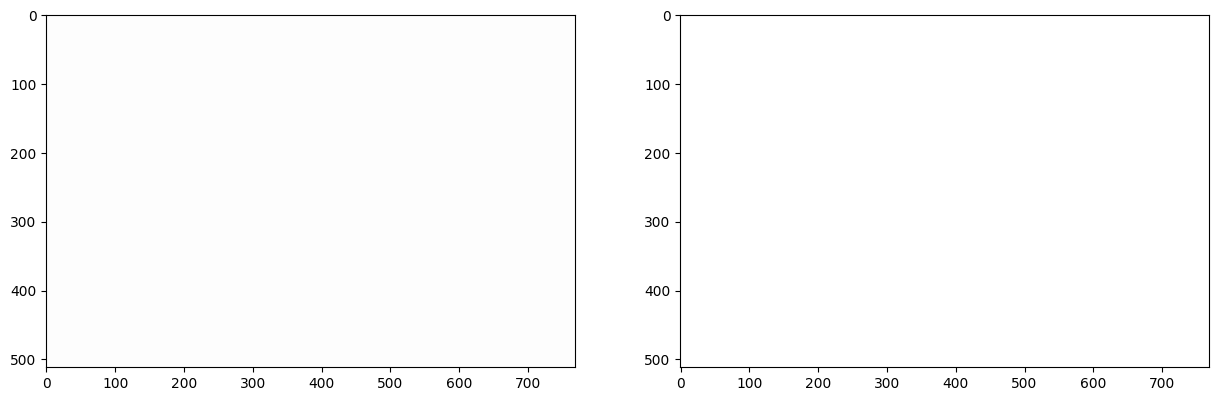

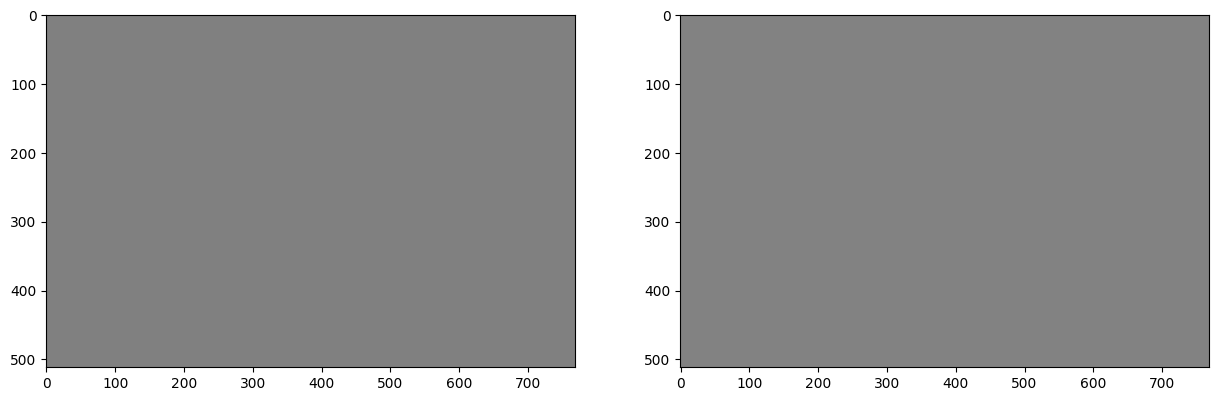

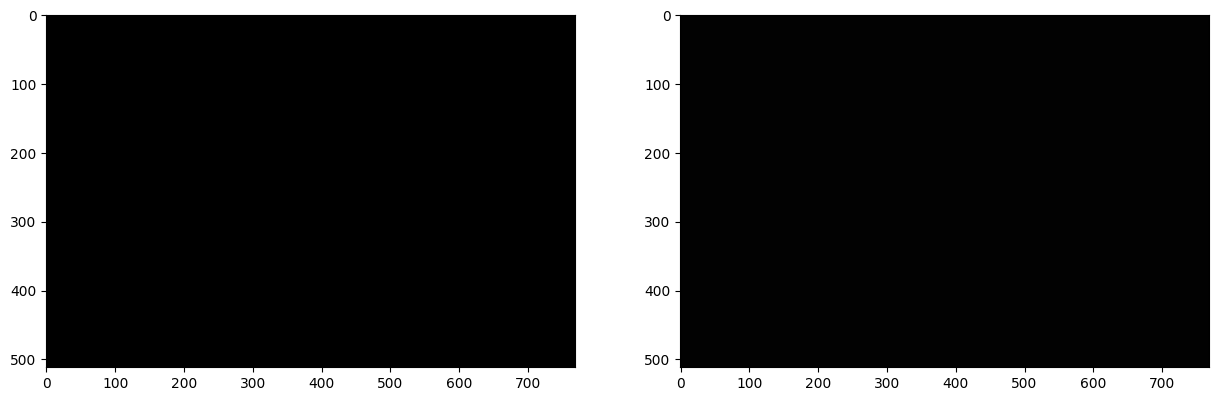

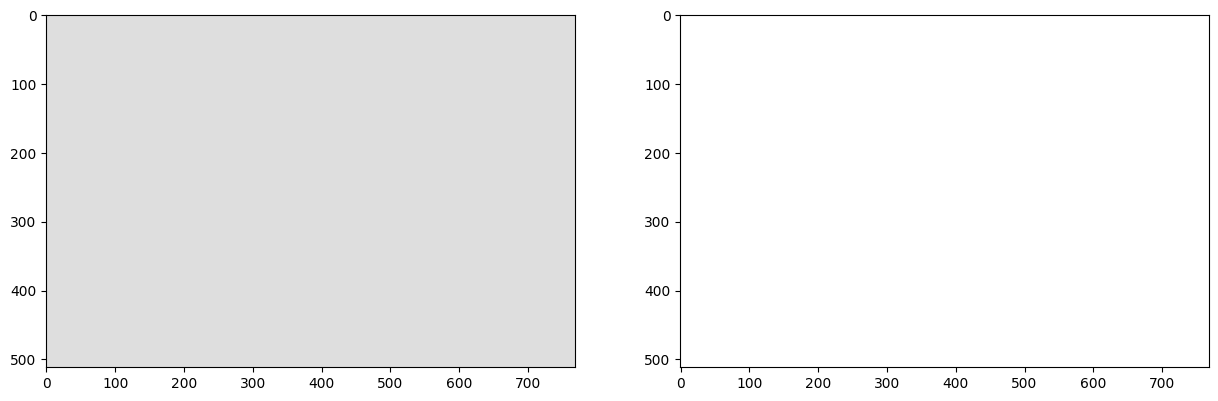

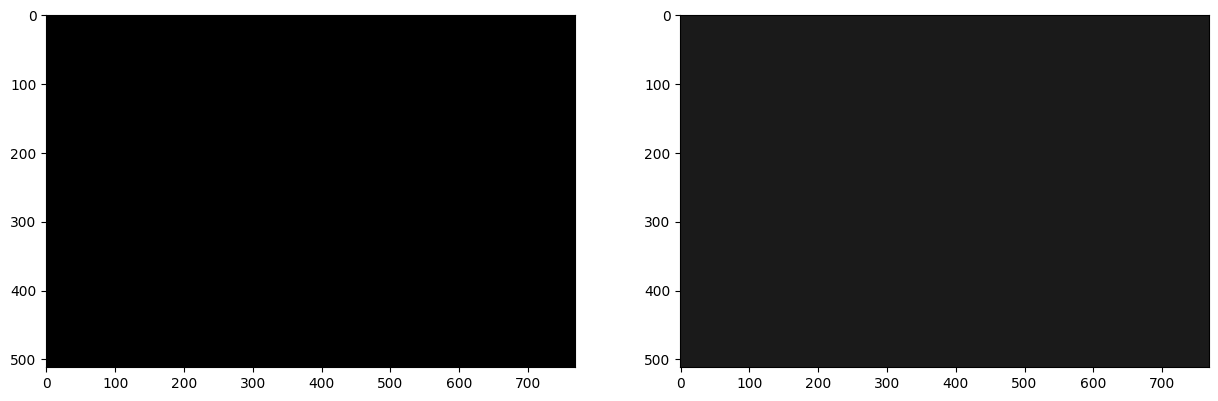

In [19]:
[imshowpair(*im) for im in test_images1]

In [20]:
WHITE255 = torch.ones((1,3,512,768),dtype=torch.float32, device="cuda")
CYAN = torch.tensor(np.array([np.ones((512,768)) * x for x in [0.56,1,1]]),dtype=torch.float32, device="cuda").unsqueeze(0)
PINK = torch.tensor(np.array([np.ones((512,768)) * x for x in [1,0.78,1]]),dtype=torch.float32, device="cuda").unsqueeze(0)
YELLOW = torch.tensor(np.array([np.ones((512,768)) * x for x in [1,1,0]]),dtype=torch.float32, device="cuda").unsqueeze(0)
test_images2 = [(WHITE255.clone(),CYAN),(WHITE255.clone(),PINK),(WHITE255.clone(),YELLOW)]


In [21]:
[[f(*im) for im in test_images2] for f in [SSIM_Loss().forward,nn.MSELoss(), loss]]


[[tensor(0.9509, device='cuda:0'),
  tensor(0.9900, device='cuda:0'),
  tensor(0.6667, device='cuda:0')],
 [tensor(0.0645, device='cuda:0'),
  tensor(0.0161, device='cuda:0'),
  tensor(0.3333, device='cuda:0')],
 [tensor(0.8205, device='cuda:0'),
  tensor(0.5738, device='cuda:0'),
  tensor(0.9883, device='cuda:0')]]

[None, None, None]

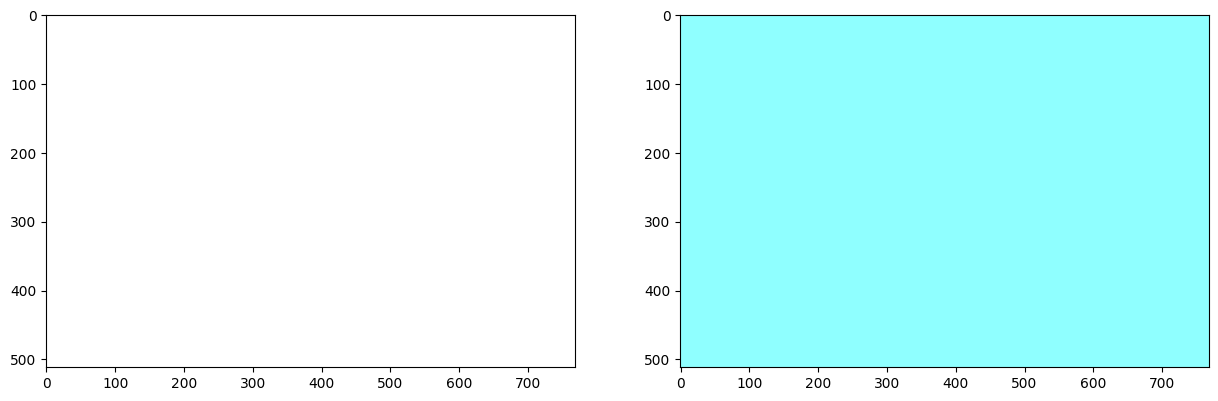

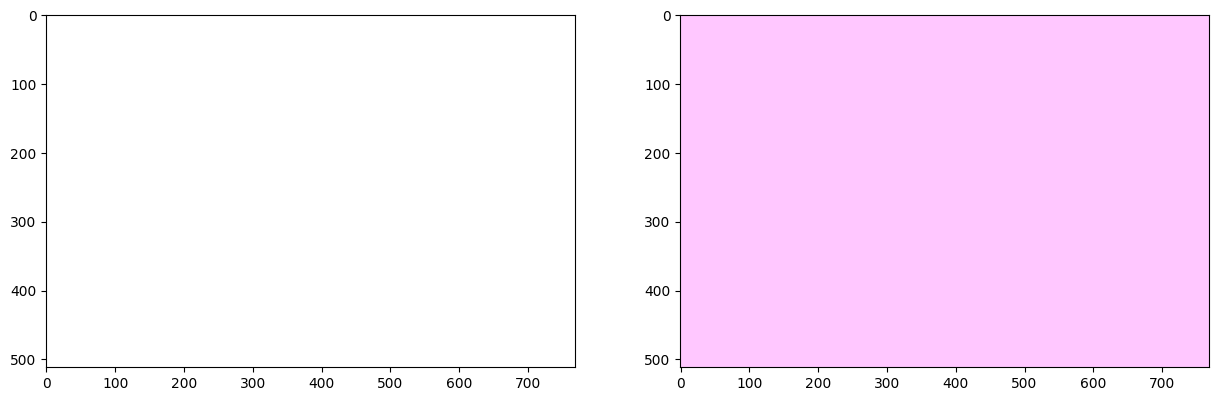

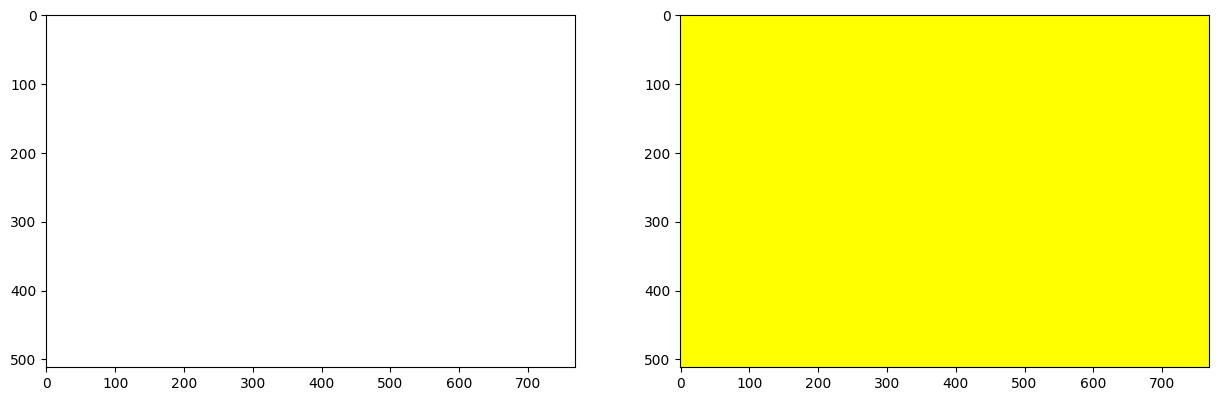

In [22]:
[imshowpair(*im) for im in test_images2]

In [23]:
GREY128 = torch.ones((1,3,512,768), device="cuda") * 128 / 255
BLACK0 = torch.ones((1,3,512,768), device="cuda") * 0 / 255
WHITE255 = torch.ones((1,3,512,768), device="cuda") * 255 / 255
CHECKERBOARD = torch.ones((512,768,3), device="cuda", dtype=torch.float32)
CHECKERBOARDFLIPED = torch.zeros((512,768,3), device="cuda", dtype=torch.float32)

for i in range(len(CHECKERBOARD)):
    for j in range(len(CHECKERBOARD[0])):
        if (i + (j%2)) % 2 == 0:
            CHECKERBOARD[i][j] -= 1
            CHECKERBOARDFLIPED[i][j] += 1
CHECKERBOARD = CHECKERBOARD.permute(2,0,1).unsqueeze(0)
CHECKERBOARDFLIPED = CHECKERBOARDFLIPED.permute(2,0,1).unsqueeze(0)
test_images2_5 = [(GREY128.clone(),CHECKERBOARD.clone()), (BLACK0.clone(),CHECKERBOARD.clone()), (WHITE255.clone(),CHECKERBOARD.clone()),(CHECKERBOARD.clone(),CHECKERBOARDFLIPED.clone())]

In [24]:
[[f(*im) for im in test_images2_5] for f in [SSIM_Loss().forward,nn.MSELoss(), loss]]

[[tensor(0.0036, device='cuda:0'),
  tensor(1.4343e-06, device='cuda:0'),
  tensor(0.0029, device='cuda:0'),
  tensor(-0.9964, device='cuda:0')],
 [tensor(0.2500, device='cuda:0'),
  tensor(0.5000, device='cuda:0'),
  tensor(0.5000, device='cuda:0'),
  tensor(1., device='cuda:0')],
 [tensor(0.3576, device='cuda:0'),
  tensor(0.7942, device='cuda:0'),
  tensor(0.8534, device='cuda:0'),
  tensor(0.5519, device='cuda:0')]]

[None, None, None, None]

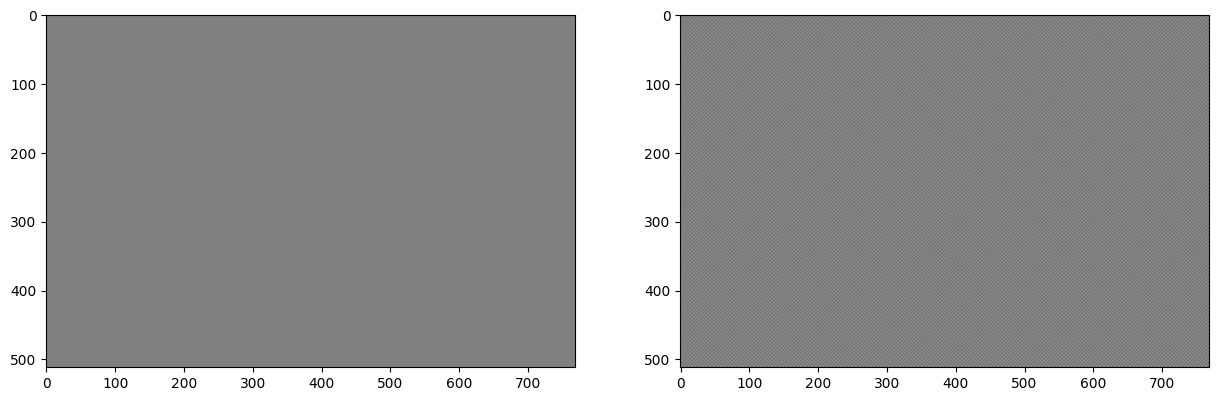

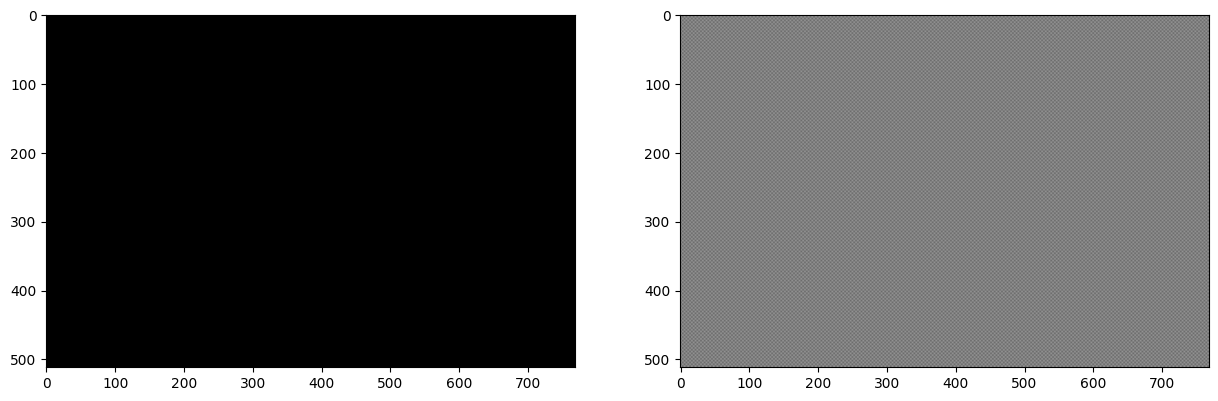

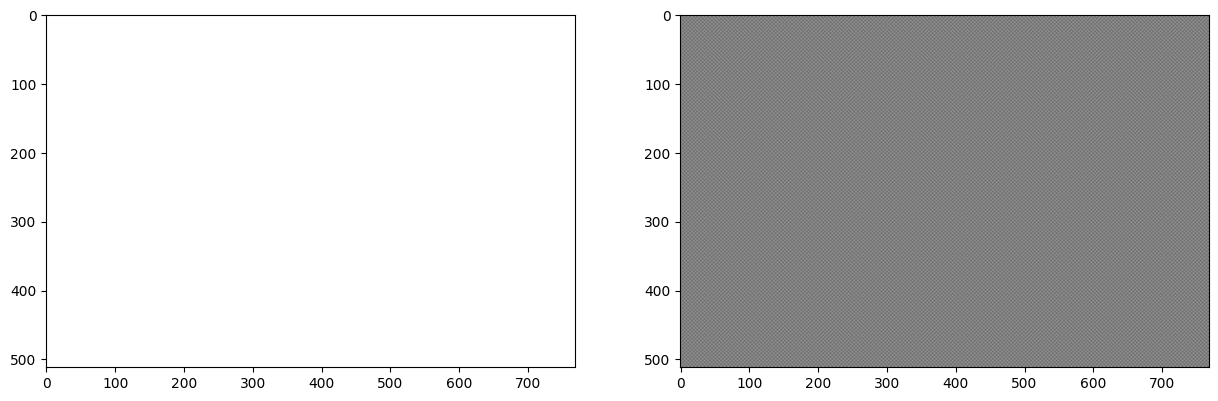

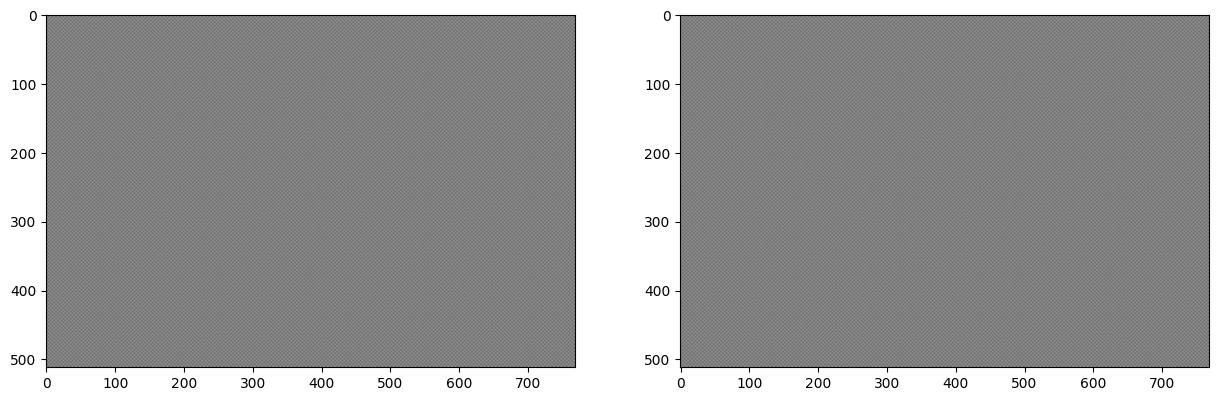

In [25]:
[imshowpair(*im) for im in test_images2_5]

In [26]:

image = 0
for i in images.get_all_images_without_anything():
    image = i
    break

image = torchvision.io.image.read_image("../../Data/Kodak/kodim07.png").permute(1,2,0).to(device="cuda", dtype=torch.float32)
print(image.shape)
randn = torch.randn((512,768,3), device="cuda")
SCALAR_ADD = augmentations.uniform_add(image,37.).permute(2,0,1).unsqueeze(0) /255 # change to get simmilar mse error
SCALAR_MUL = augmentations.uniform_decimal_multiplication(image,0.65).permute(2,0,1).unsqueeze(0)/255
EXP_NOISE = augmentations.Exp_noice(image,randn.clone(),0.15).permute(2,0,1).unsqueeze(0)/255
POIS_NOISE = augmentations.Poiss_noice(image,torch.rand((512,768,3), device="cuda"),0.63).permute(2,0,1).unsqueeze(0)/255
SALT = augmentations.salt(image,randn.clone(),-1.8).permute(2,0,1).unsqueeze(0)/255
BOXBLUR = augmentations.box_blur_5x5(image).permute(2,0,1).unsqueeze(0)/255
UNSHARP_MASK = augmentations.Unsharp_masking_5x5(image).permute(2,0,1).unsqueeze(0)/255

image = image.permute(2,0,1).unsqueeze(0)/255
print(image.shape)
print(SCALAR_ADD.shape)
test_images3 = [(image.clone(),SCALAR_ADD),(image.clone(),SCALAR_MUL),(image.clone(),EXP_NOISE),(image.clone(),POIS_NOISE),(image.clone(),SALT),(image.clone(),BOXBLUR),(image.clone(),UNSHARP_MASK)]

torch.Size([512, 768, 3])
torch.Size([1, 3, 512, 768])
torch.Size([1, 3, 512, 768])


In [27]:
[[f(*im) for im in test_images3] for f in [SSIM_Loss().forward,nn.MSELoss(), loss]]


[[tensor(0.9296, device='cuda:0'),
  tensor(0.8780, device='cuda:0'),
  tensor(0.2989, device='cuda:0'),
  tensor(0.3602, device='cuda:0'),
  tensor(0.3991, device='cuda:0'),
  tensor(0.8545, device='cuda:0'),
  tensor(0.9604, device='cuda:0')],
 [tensor(0.0210, device='cuda:0'),
  tensor(0.0239, device='cuda:0'),
  tensor(0.0191, device='cuda:0'),
  tensor(0.0207, device='cuda:0'),
  tensor(0.0134, device='cuda:0'),
  tensor(0.0017, device='cuda:0'),
  tensor(0.0007, device='cuda:0')],
 [tensor(0.3548, device='cuda:0'),
  tensor(0.4726, device='cuda:0'),
  tensor(0.5196, device='cuda:0'),
  tensor(0.4825, device='cuda:0'),
  tensor(0.5234, device='cuda:0'),
  tensor(0.3674, device='cuda:0'),
  tensor(0.2806, device='cuda:0')]]

[None, None, None, None, None, None, None]

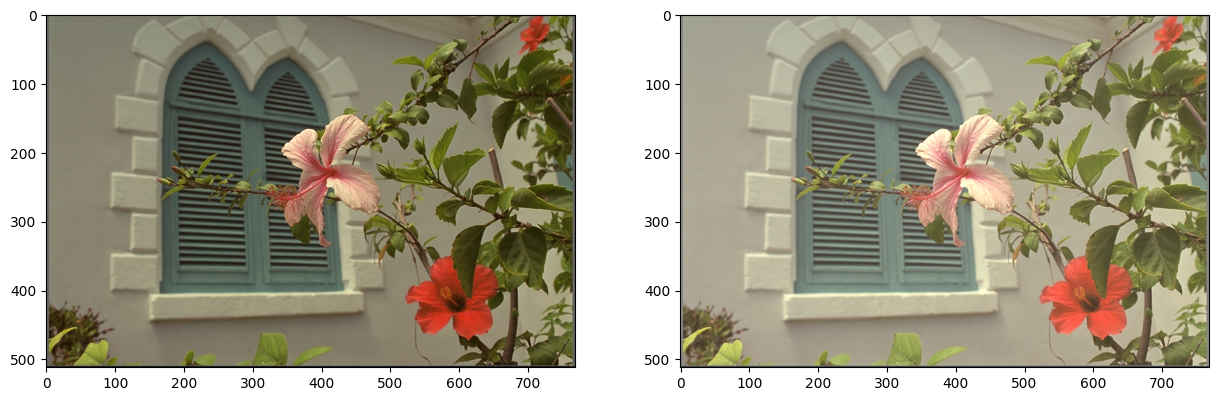

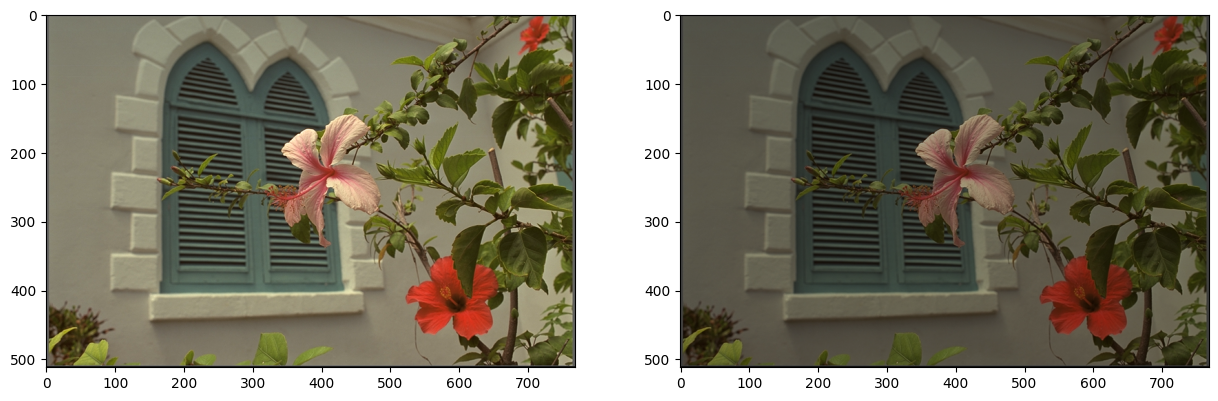

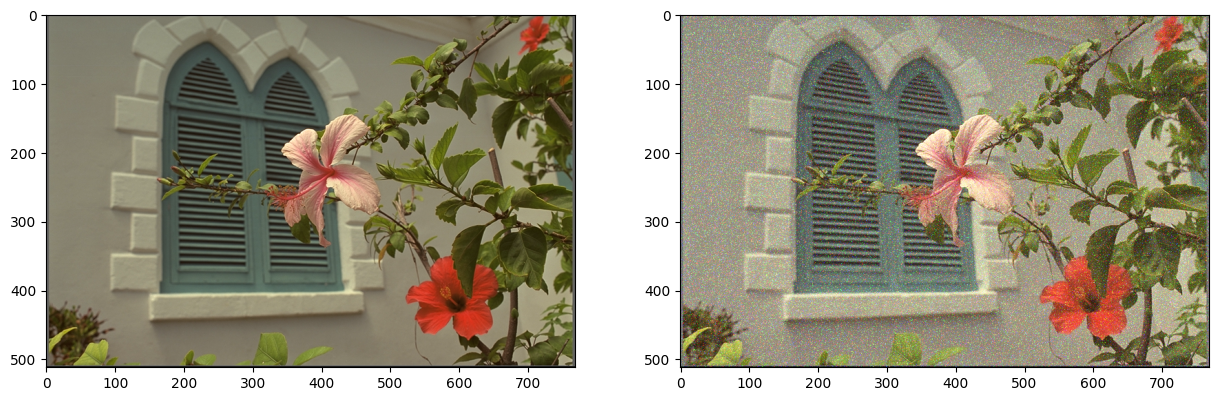

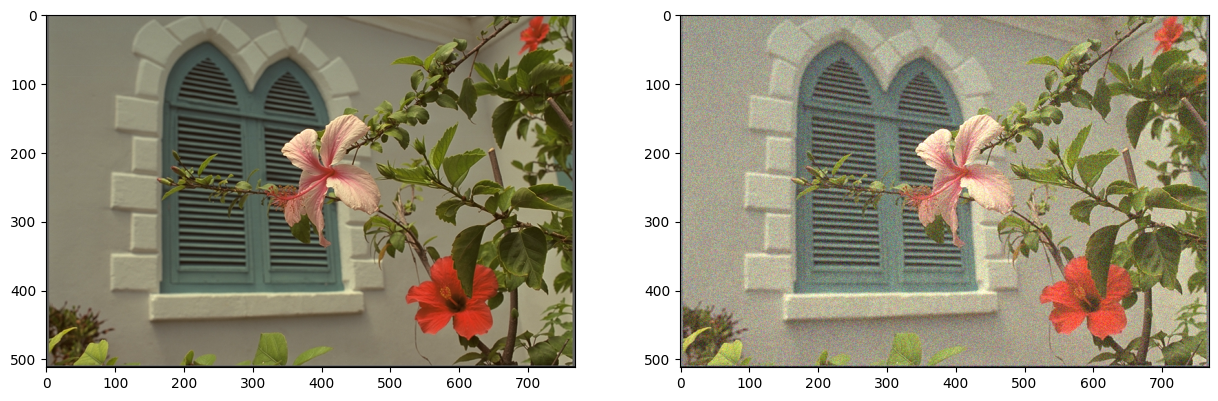

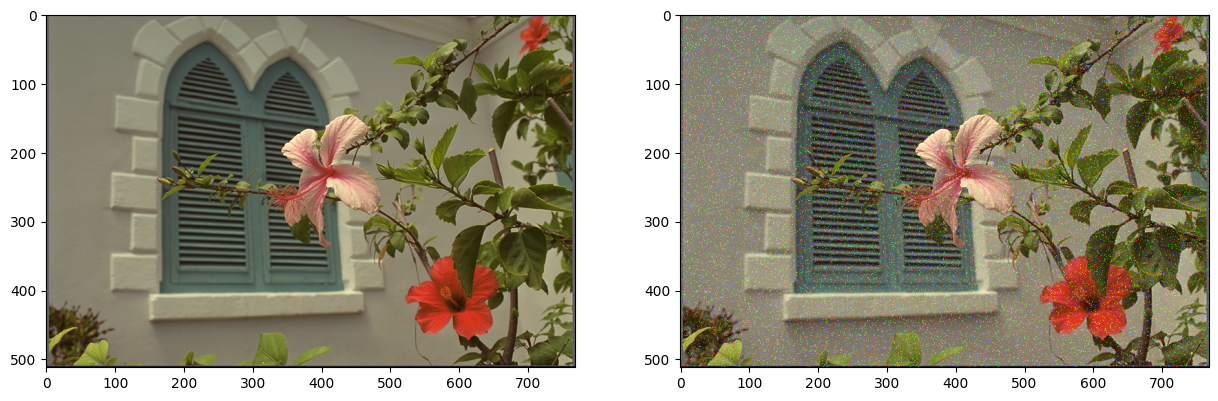

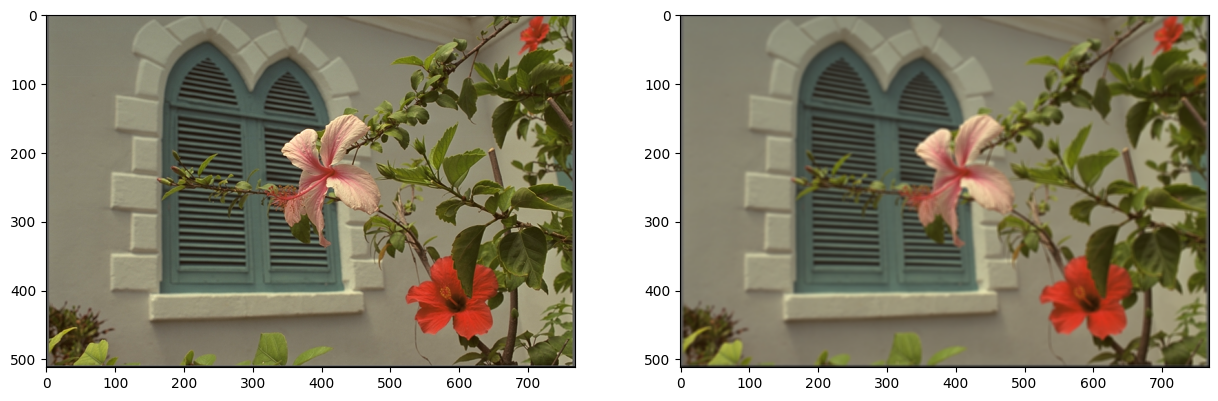

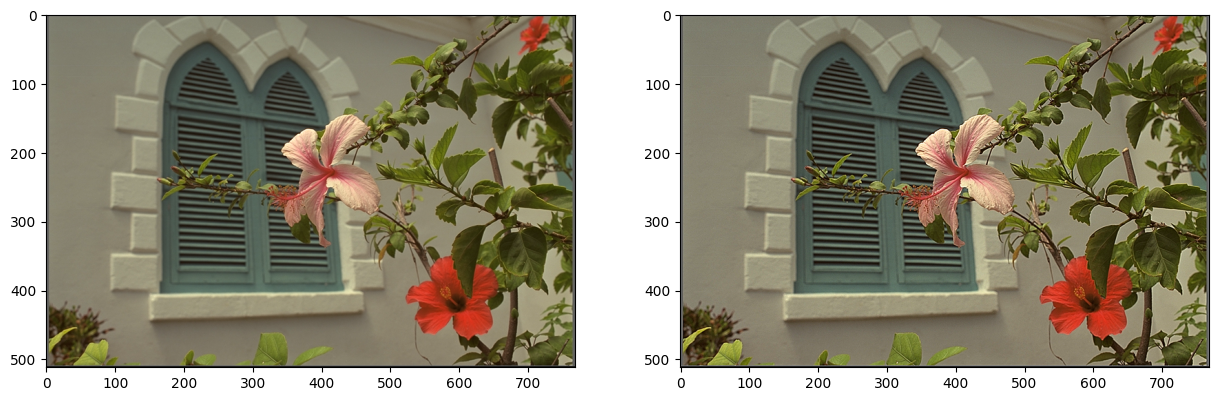

In [28]:
[imshowpair(*im) for im in test_images3]